In [20]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
!pip install torchdiffeq
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
from scipy import io
import argparse
import os
import pickle
import matplotlib.pyplot as plt
from timeit import default_timer
from google.colab import drive
drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
directory = "drive/MyDrive/"#"spring-runs_train/" #/mnt/data/datasets/physical_system_benchmark/experiment_output/spring/spring/run/data_gen/spring-runs_train-spring-n1000-t805-n0_00001/"
npz = np.load(directory + "trajectories.npz")
nb_trajs = 1000
start_traj = 0
p1, q1, dqdt1, dpdt1, t1 = np.zeros((nb_trajs,805)), np.zeros((nb_trajs,805)), np.zeros((nb_trajs,805)), np.zeros((nb_trajs,805)), np.zeros((nb_trajs,805))
with np.load(directory + "trajectories.npz") as npz:
  for i in range(start_traj, start_traj + nb_trajs):
    p1[i:i+1,:], q1[i:i+1,:], dqdt1[i:i+1,:], dpdt1[i:i+1,:], t1[i:i+1,:] = npz[npz.files[5*i+0]].T, npz[npz.files[5*i+1]].T, npz[npz.files[5*i+2]].T, npz[npz.files[5*i+3]].T, npz[npz.files[5*i+4]].T #The first trajectory
q_exact = torch.tensor(q1, dtype = torch.float32)
p_exact = torch.tensor(p1, dtype = torch.float32)
t = torch.tensor(t1[0], dtype = torch.float32)
exact = torch.cat((q_exact.reshape(nb_trajs,-1,1), p_exact.reshape(nb_trajs,-1,1)), dim=-1)

In [22]:
test_trajs = 100
train_loader = DataLoader(exact[:(nb_trajs-test_trajs)], batch_size=64)
test_loader  = DataLoader(exact[(nb_trajs-test_trajs):], batch_size=64)

In [23]:
print(exact.shape)
print(len(exact[(nb_trajs-test_trajs):]))

torch.Size([1000, 805, 2])
100


In [24]:
class Lyapunov(nn.Module):
  def __init__(self, in_nodes, layers, activation):
    super(Lyapunov, self).__init__()
    self.in_nodes = in_nodes
    self.layers = layers
    self.act = activation
    self.w0 = nn.Linear(in_nodes, in_nodes)
    self.w1 = nn.Linear(in_nodes, 1)
    self.u1 = nn.Parameter(torch.Tensor(1, in_nodes))
    nn.init.xavier_uniform_(self.u1)
    self.g0 = self.g(torch.zeros(in_nodes))
  def g(self, x):
    z = self.act(self.w0(x))
    z = self.act(self.w1(x)  + F.linear(z, self.u1.exp()))
    return z
  def forward(self, x):
    return self.act(self.g(x) - self.g0) + torch.sum(x**2, dim=1).reshape(-1,1)/100
# class Lyapunov(nn.Module):
#   def __init__(self, in_nodes, layers, activation):
#     super(Lyapunov, self).__init__()
#     self.in_nodes = in_nodes
#     self.layers = layers
#     self.act = activation
#     self.W = [nn.Linear(in_nodes, in_nodes)]
#     self.U = []
#     for i in range(layers):
#       self.W.append(nn.Linear(in_nodes, in_nodes))
#       self.U.append(nn.Linear(in_nodes, in_nodes))
#     self.W.append(nn.Linear(in_nodes, 1))
#     self.U.append(nn.Linear(in_nodes, 1))
#     self.g0 = self.g(torch.zeros(in_nodes))
#   def g(self, x):
#     z = self.act(self.W[0](x))
#     for i in range(self.layers):
#       z = self.act(self.W[i+1](x) + self.U[i](z)**2)
#     z = self.act(self.W[self.layers+1](x) + self.U[self.layers](z)**2)
#     return z
#   def forward(self, x):
#     return self.act(self.g(x) - self.g0) + torch.norm(x, p=2)/100

In [25]:
class ODEFunc(nn.Module):
    def __init__(self, in_nodes, hid_nodes, v_layers, v_act):
        super(ODEFunc, self).__init__()
        self.fc0 = nn.Linear(in_nodes+1, hid_nodes)
        self.fc1 = nn.Linear(hid_nodes, in_nodes)
        self.V = Lyapunov(in_nodes, v_layers, v_act)
    def forward(self, t, x):
        x = x.requires_grad_(True)
        tt = torch.ones_like(x[...,:1], requires_grad=True)*t
        xt = torch.cat((tt, x), dim=-1)
        fx = self.fc0(xt)
        fx = F.gelu(fx)
        fx = self.fc1(fx)
        # Vx = self.V(x)
        # grad_Vx = torch.autograd.grad(Vx, x, torch.ones(Vx.shape), create_graph=True, allow_unused=True, retain_graph=True)[0]
        # alpha = 1
        # fx = fx - grad_Vx*torch.relu(torch.sum(grad_Vx*fx,dim=1).reshape(-1,1) + alpha*Vx)/torch.sum(grad_Vx**2, dim=1).reshape(-1,1)
        return fx

In [26]:
class NODE(nn.Module):
    def __init__(self, in_nodes, hid_nodes, tol, v_layers, v_act):
        super(NODE, self).__init__()
        self.ode = ODEFunc(in_nodes, hid_nodes, v_layers, v_act)
        self.fc0 = nn.Linear(2, in_nodes)
        self.fc1 = nn.Linear(in_nodes, 2)
        self.tol = tol
    def forward(self, x):
        x = x.requires_grad_(True)
        x = x.reshape(x.shape[0], -1)
        x = self.fc0(x)
        x0 = x
        x = odeint(self.ode, x, torch.tensor([0., 1.], device=x.device), atol=self.tol, rtol=self.tol)[-1]
        x = self.fc1(x)
        return x

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# model = NODE(32, 128, 1e-5, 3, nn.Softplus()).to(device)
latent_channels = 8
hidden_layers = 16
odefunc = ODEFunc(latent_channels, hidden_layers, 2, nn.ReLU())
prelayer = nn.Linear(2, latent_channels)
postlayer = nn.Linear(latent_channels, 2)
params = list(odefunc.parameters()) + list(prelayer.parameters()) + list(postlayer.parameters())
optim = torch.optim.Adam(params, lr=1e-3)
loss_fn = nn.MSELoss()
epochs = 500
tol = 1e-5
mse_train_losses = []
mse_test_losses = []
lyap_train_losses = []
lyap_test_losses = []
accuracies = []

cpu


In [39]:
Nt = 805//35
alpha = 5
for i in range(epochs):
    t = default_timer()
    lyap_train_loss = 0
    mse_train_loss = 0
    mse_test_loss = 0
    lyap_test_loss = 0
    for x in train_loader:
        x0 = x[:,0,:].to(device).requires_grad_(True)
        z0 = prelayer(x0)
        zt = odeint(odefunc, z0, torch.linspace(0,1,Nt), atol=tol, rtol=tol)
        pred = postlayer(zt)
        pred = pred.permute(1,0,2)
        x = x[:,::35,:]
        # loss = loss_fn(pred,x[:,::35,:])
        loss = torch.tensor(0.0, requires_grad=True, device=device)
        loss_now = loss_fn(pred[0], x[0])
        for j in range(1,pred.shape[0]):
          loss_prev = loss_now
          loss_now = loss_fn(pred[j], x[j])
          loss = loss + torch.relu(loss_now + (alpha-1)*loss_prev)
        optim.zero_grad()
        loss.backward()
        optim.step()
        lyap_train_loss += loss.item()
        mse_train_loss += loss_fn(pred, x).item()
    for x in test_loader:
        x = x[:,::35,:]
        x0 = x[:,0,:].to(device).requires_grad_(True)
        z0 = prelayer(x0)
        zT = odeint(odefunc, z0, torch.linspace(0,1,Nt), atol=tol, rtol=tol)
        pred = postlayer(zT)
        pred = pred.permute(1,0,2)
        loss = torch.tensor(0.0, requires_grad=True, device=device)
        loss_now = loss_fn(pred[0], x[0])
        for j in range(1,pred.shape[0]):
          loss_prev = loss_now
          loss_now = loss_fn(pred[j], x[j])
          loss = loss + torch.relu(loss_now + (alpha-1)*loss_prev)
        lyap_test_loss += loss.item()
        mse_test_loss += loss_fn(pred, x).item()
    mse_train_loss /= len(train_loader)
    mse_test_loss /= len(test_loader)
    lyap_train_loss /= len(train_loader)
    lyap_test_loss /= len(test_loader)
    mse_train_losses.append(mse_train_loss)
    mse_test_losses.append(mse_test_loss)
    lyap_train_losses.append(lyap_train_loss)
    lyap_test_losses.append(lyap_test_loss)
    if i%50==0 or i ==epochs-1:
      print(i, default_timer()-t, lyap_train_loss, lyap_test_loss, mse_train_loss, mse_test_loss)

0 6.779311254000277 0.0029898957368762543 0.0029167126631364226 9.79686507586545e-06 1.1913214166270336e-05
50 6.7548844369994185 0.004994502519063341 0.009101619478315115 1.6165619460177064e-05 3.687190110213123e-05


KeyboardInterrupt: ignored

In [40]:
torch.save([lyap_train_loss, lyap_test_loss, mse_train_loss, mse_test_loss], "lyanet_pi_spring_losses.data")

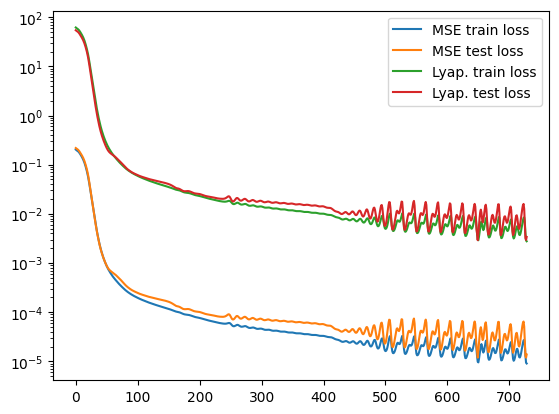

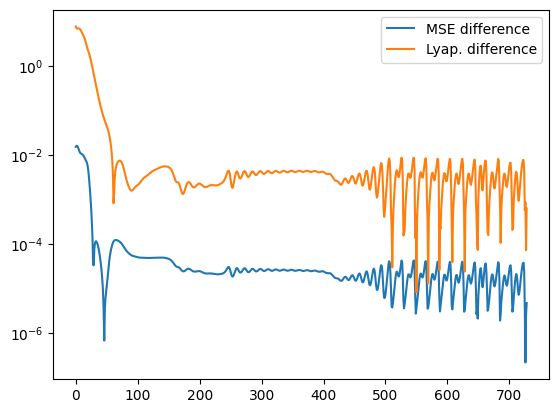

In [41]:
plt.plot(range(len(mse_train_losses)), np.array(mse_train_losses), label="MSE train loss")
plt.plot(range(len(mse_test_losses)), np.array(mse_test_losses), label="MSE test loss")
plt.plot(range(len(lyap_train_losses)), np.array(lyap_train_losses), label="Lyap. train loss")
plt.plot(range(len(lyap_test_losses)), np.array(lyap_test_losses), label="Lyap. test loss")
plt.yscale('log')
plt.legend()
plt.show()
plt.plot(range(len(mse_test_losses)), np.abs(np.array(mse_test_losses)-np.array(mse_train_losses)), label="MSE difference")
plt.plot(range(len(lyap_test_losses)), np.abs(np.array(lyap_test_losses)-np.array(lyap_train_losses)), label="Lyap. difference")
plt.legend()
plt.yscale('log')
plt.show()